2021/06/15

#Vision Transformer による絵画の作者予測 

収蔵品データセットに作品数が20以上含まれる画家を対象として行う

参考：

* [google-research
/
vision_transformer](https://github.com/google-research/vision_transformer)
* [TensorFlow Core / tf.dataを使って画像をロードする](https://www.tensorflow.org/tutorials/load_data/images?hl=ja)
* [google colabでVision TransformerのFine Tuningをやってみた - Qiita](https://qiita.com/kanataken/items/dc579fa0f53b7f84ef25)

In [ ]:
import pandas as pd
import numpy as np
import numpy.random as random
from pandas import Series, DataFrame

In [ ]:
!git clone https://github.com/obrmmk/ViT_MET_datasets.git

train_data=pd.read_csv('./ViT_MET_datasets/painting/twe/painting_twe_train.csv')
test_data=pd.read_csv('./ViT_MET_datasets/painting/twe/painting_twe_test.csv')

Cloning into 'ViT_MET_datasets'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 19 (delta 6), reused 19 (delta 6), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [ ]:
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull
!pip install -qr vision_transformer/vit_jax/requirements.txt

Cloning into 'vision_transformer'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 35 (delta 5), reused 14 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.
Already up to date.
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 81kB 12.6MB/s 
     |████████████████████████████████| 184kB 42.8MB/s 
     |████████████████████████████████| 92kB 13.0MB/s 
     |████████████████████████████████| 168.3MB 72kB/s 


In [ ]:
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')
from vit_jax import checkpoint
from vit_jax import hyper
from vit_jax import input_pipeline
from vit_jax import logging
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train
import pathlib
import tensorflow as tf
import csv
import pandas as pd

logger = logging.setup_logger('./logs')

In [ ]:
model = 'ViT-B_16'
![ -e "$model".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model".npz .

Copying gs://vit_models/imagenet21k/ViT-B_16.npz...
/ [1 files][393.7 MiB/393.7 MiB]                                                
Operation completed over 1 objects/393.7 MiB.                                    


In [ ]:
import tensorflow as tf
from tensorflow import keras

AUTOTUNE = tf.data.experimental.AUTOTUNE
label_names = sorted(list(set([item for item in train_data['Artist Display Name']])))
label_to_index_pre = dict((index,name) for index,name in enumerate(label_names))
df = pd.DataFrame.from_dict(label_to_index_pre, orient='index')
df = df.reset_index()
df = df.set_axis(['label', 'Artist Display Name'], axis=1)
all_image_labels=[]
for i in range(len(train_data)):
  all_image_labels.append(int(df[df['Artist Display Name'] == train_data.loc[i]['Artist Display Name']]['label']))
all_image_labels_i = [int(s) for s in all_image_labels]
n_labels = len(np.unique(all_image_labels_i))

count=0
def create_file(url):
  global count
  count+=1
  image = tf.keras.utils.get_file(str(count)+'.jpg', origin=url)
  return image

all_image_paths = list(train_data['primaryImage'])
image_count = len(all_image_paths)

In [ ]:
!pip install tqdm
from tqdm.notebook import tqdm

for i in tqdm(all_image_paths):
  create_file(i)

2842624/2837847 [==============================] - 0s 0us/step



In [ ]:
import pathlib

data_root = pathlib.Path('/root/.keras/datasets/')
all_image_paths = sorted(list(sorted(data_root.glob('?.jpg'))))+sorted(list(sorted(data_root.glob('??.jpg'))))+sorted(list(sorted(data_root.glob('???.jpg'))))
all_image_paths = [str(path) for path in all_image_paths]
all_image_labels_o = np.eye(n_labels)[all_image_labels_i] 

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [384, 384])
  image /= 255.0  
  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels_o, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

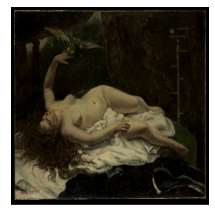

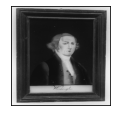

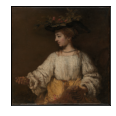

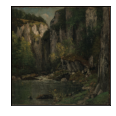

In [ ]:
plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
 plt.subplot(2,2,n+1)
 plt.imshow(image)
 plt.grid(False)
 plt.xticks([])
 plt.yticks([])
 plt.show()

In [ ]:
image_count

175

In [ ]:
BATCH_SIZE = 5
ds = image_label_ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE) 
batch = next(iter(ds.as_numpy_iterator()))

In [ ]:
VisionTransformer = models.KNOWN_MODELS[model].partial(num_classes=10)
_, params = VisionTransformer.init_by_shape(
    jax.random.PRNGKey(0),
    [(batch[0].shape, 'float32')])

In [ ]:
params = checkpoint.load_pretrained(
    pretrained_path=f'{model}.npz',
    init_params=params,
    model_config=models.CONFIGS[model],
    logger=logger,
)

params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['cls']).__name__, params['cls'].shape)
print('params_repl.cls:', type(params_repl['cls']).__name__, params_repl['cls'].shape)

vit_apply_repl = jax.pmap(VisionTransformer.call)

2021-06-15 00:40:42,586 [WARNING] vit_jax.logging: Inspect recovered empty keys:
{'pre_logits'}
2021-06-15 00:40:42,587 [INFO] vit_jax.logging: Inspect extra keys:
{'pre_logits/bias', 'pre_logits/kernel'}
2021-06-15 00:40:42,591 [INFO] vit_jax.logging: load_pretrained: drop-head variant
2021-06-15 00:40:42,595 [INFO] vit_jax.logging: load_pretrained: resized variant: (1, 197, 768) to (1, 577, 768)
2021-06-15 00:40:42,597 [INFO] vit_jax.logging: load_pretrained: grid-size from 14 to 24


params.cls: ndarray (1, 1, 768)
params_repl.cls: ShardedDeviceArray (1, 1, 1, 768)


/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:317: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:304: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


In [ ]:
total_steps = 35
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
accum_steps = 5
base_lr = 0.03

In [ ]:
update_fn_repl = train.make_update_fn(VisionTransformer.call, accum_steps)

opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

lr_fn = hyper.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
lr_iter = hyper.lr_prefetch_iter(lr_fn, 0, total_steps)
update_rngs = jax.random.split(jax.random.PRNGKey(0), jax.local_device_count())

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:317: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:304: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


In [ ]:
import tqdm

for step, batch, lr_repl in zip(
    tqdm.notebook.trange(1, total_steps + 1),
    ds.as_numpy_iterator(),
    lr_iter
):
  batch_dict = {
      'image':np.array([batch[0]]),
      'label':np.array([batch[1]])
  }
  opt_repl, loss_repl, update_rngs = update_fn_repl(
      opt_repl, lr_repl, batch_dict, update_rngs)

In [ ]:
vit_apply_repl = jax.pmap(VisionTransformer.call)

label_names_test = sorted(list(set([item for item in test_data['Artist Display Name']])))
label_to_index_pre_test = dict((index,name) for index,name in enumerate(label_names_test))
df_test = pd.DataFrame.from_dict(label_to_index_pre_test, orient='index')
df_test = df_test.reset_index()
df_test = df_test.set_axis(['label', 'Artist Display Name'], axis=1)
all_image_labels_test=[]
for i in range(len(test_data)):
  all_image_labels_test.append(int(df_test[df_test['Artist Display Name'] == test_data.loc[i]['Artist Display Name']]['label']))
all_image_labels_test_i = [int(s) for s in all_image_labels_test]
n_labels_test = len(np.unique(all_image_labels_test_i))

test_image_paths = list(test_data['primaryImage'])
image_count2 = len(test_image_paths)

In [ ]:
from tqdm.notebook import tqdm
for i in tqdm(test_image_paths):
  create_file(i)

2826240/2823006 [==============================] - 0s 0us/step



In [ ]:
data_root = pathlib.Path('/root/.keras/datasets/')
test_image_paths = sorted(list(sorted(data_root.glob('?.jpg'))))+sorted(list(sorted(data_root.glob('??.jpg'))))+sorted(list(sorted(data_root.glob('???.jpg'))))
test_image_paths = [str(path) for path in test_image_paths][image_count:]
test_image_paths_o = np.eye(n_labels_test)[all_image_labels_test_i] 

path_ds_test = tf.data.Dataset.from_tensor_slices(test_image_paths)
image_ds_test = path_ds_test.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

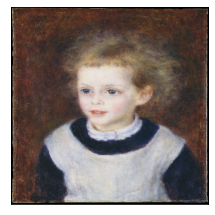

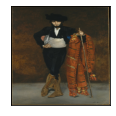

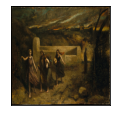

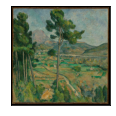

In [ ]:
#image_ds_testの確認
plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds_test.take(4)):
 plt.subplot(2,2,n+1)
 plt.imshow(image)
 plt.grid(False)
 plt.xticks([])
 plt.yticks([])
 plt.show()

In [ ]:
BATCH_SIZE = 5
ds_test = image_ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tqdm

In [ ]:
steps = image_count2 // BATCH_SIZE
for i, batch in zip(tqdm.notebook.trange(steps), ds_test.as_numpy_iterator()):
    if i == 0:
        predicted = vit_apply_repl(opt_repl.target, batch[np.newaxis, :])
        predicted = flax.nn.softmax(predicted)
        predict_prob = predicted[0]
    else:
        predicted = vit_apply_repl(opt_repl.target, batch[np.newaxis, :])
        predicted = flax.nn.softmax(predicted)
        predict_prob = np.append(predict_prob, predicted[0], axis=0)

In [ ]:
submit_file = pd.DataFrame(predict_prob)
submit_file.index = [path.replace("test/", "") for path in test_image_paths]
submit_file.to_csv("result_file.csv", header=False)

In [ ]:
submit_file.columns = label_names

In [ ]:
submit_file

,Auguste Renoir,Camille Corot,Edgar Degas,Edouard Manet,Gilbert Stuart,Gustave Courbet,John Frederick Kensett,Paul Cézanne,Rembrandt (Rembrandt van Rijn),William P. Chappel
/root/.keras/datasets/176.jpg,0.129738,0.187555,0.060334,0.081669,0.145707,0.074865,0.052019,0.110663,0.071338,0.086113
/root/.keras/datasets/177.jpg,0.084926,0.164872,0.071462,0.097706,0.139854,0.088203,0.065544,0.111366,0.090655,0.085412
/root/.keras/datasets/178.jpg,0.108779,0.178564,0.079583,0.091985,0.087363,0.119331,0.064951,0.099698,0.077600,0.092145
/root/.keras/datasets/179.jpg,0.169517,0.199704,0.054636,0.069369,0.060472,0.082740,0.055896,0.151988,0.040243,0.115435
/root/.keras/datasets/180.jpg,0.171334,0.135386,0.088724,0.096476,0.076949,0.133670,0.059373,0.107145,0.058569,0.072375
...,...,...,...,...,...,...,...,...,...,...
/root/.keras/datasets/246.jpg,0.213440,0.123280,0.067972,0.081751,0.057790,0.080221,0.051099,0.193336,0.043425,0.087686
/root/.keras/datasets/247.jpg,0.120705,0.136235,0.084795,0.094152,0.102596,0.099482,0.072914,0.111098,0.089162,0.088862
/root/.keras/datasets/248.jpg,0.100937,0.153721,0.078109,0.083946,0.139598,0.112231,0.060463,0.107022,0.099068,0.064905
/root/.keras/datasets/249.jpg,0.101356,0.156213,0.067777,0.081229,0.193594,0.085492,0.048325,0.117149,0.083596,0.065268


In [ ]:
results = pd.DataFrame(submit_file.idxmax(axis=1))
results

,0
/root/.keras/datasets/176.jpg,Camille Corot
/root/.keras/datasets/177.jpg,Camille Corot
/root/.keras/datasets/178.jpg,Camille Corot
/root/.keras/datasets/179.jpg,Camille Corot
/root/.keras/datasets/180.jpg,Auguste Renoir
...,...
/root/.keras/datasets/246.jpg,Auguste Renoir
/root/.keras/datasets/247.jpg,Camille Corot
/root/.keras/datasets/248.jpg,Camille Corot
/root/.keras/datasets/249.jpg,Gilbert Stuart


In [ ]:
results = pd.DataFrame(results)
results.index = [path.replace("test/", "") for path in test_image_paths]
results.to_csv("results.csv", header=False)